In [1]:
%load_ext autoreload
%autoreload 2
# %matplotlib widget

import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"] = '1'

from encoding_information.gpu_utils import limit_gpu_memory_growth
limit_gpu_memory_growth()

from cleanplots import *
import matplotlib.pyplot as plt
from bsccm import BSCCM
import numpy as onp
import time
from tqdm import tqdm
from encoding_information.bsccm_utils import *
from encoding_information.plot_utils import *
from encoding_information.bsccm_utils import *
from encoding_information.information_estimation import *
from encoding_information.image_utils import *
from matplotlib.colors import LinearSegmentedColormap
from jax import jit
import jax.numpy as np


bsccm = BSCCM('/home/hpinkard_waller/data/BSCCM/')

2024-01-08 14:03:37.131808: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-01-08 14:03:37.910178: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cublas/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_cupti/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvcc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_nvrtc/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/python3.10/site-packages/nvidia/cuda_runtime/lib:/home/hpinkard_waller/mambaforge/envs/phenotypes/lib/pyth

Opening BSCCM
Opened BSCCM


## Estimate stationary gaussian processes and draw samples from them

In [2]:
# images used to generate the covariance matrix
num_images = 10000
num_patches = 10000
edge_crop = 24

patch_size = 50 # the size of patches to estimate the covariance matrix from
sample_size = 128 - 2 * edge_crop # the size of the samples to generate
num_samples = 10

# patch_size = 5
# sample_size = 10

photons_per_pixel = 300

channels = ['LED119', 'DPC_Right', 'Brightfield']
eigenvalue_floors = [1e-2, 1e-2, 1e2]
# channels = ['LED119', 'DPC_Right']
# channels = ['LED119']


image_samples_gp = {}
image_samples_pcnn = {}
noisy_patches_by_channel = {}
images_by_channel = {}

for channel_index, channel in tqdm(enumerate(channels), desc='Fitting models and sampling'):
    images = load_bsccm_images(bsccm, channel, num_images=num_images, edge_crop=edge_crop, convert_units_to_photons=True, median_filter=False)
    images_by_channel[channel] = images[:num_samples * 10]
    noisy_images = add_shot_noise_to_experimenal_data(images, photon_fraction=photons_per_pixel / np.mean(images))
    images = None # save memory

    print('getting patches')
    noisy_patches = extract_patches(noisy_images, patch_size=patch_size, num_patches=num_patches, seed=1234)
    noisy_patches_by_channel[channel] = noisy_patches[: num_samples * 10] # for display

    print('fitting stationary GP')
    gp = StationaryGaussianProcess(noisy_patches, eigenvalue_floor=eigenvalue_floors[channel_index])
    _ = gp.fit(noisy_patches, verbose=True)
    cov_mat = gp.get_cov_mat()

    print('fitting PixelCNN')
    pcnn = PixelCNN()
    pcnn.fit(noisy_patches, max_epochs=25, verbose=True)

    print('generating samples for PixelCNN')
    image_samples_pcnn[channel] = pcnn.generate_samples(num_samples, sample_shape=sample_size, seed=channel_index * 1000, verbose=True)

    print('generating samples for stationary GP')
    image_samples_gp[channel] = gp.generate_samples(num_samples, sample_shape=sample_size, seed=channel_index * 1000, verbose=True)


Fitting models and sampling: 0it [00:00, ?it/s]

getting patches
fitting stationary GP


2024-01-08 14:07:06.469977: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:42] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.


Initial validation NLL: 304.42


Epoch 1: 100%|██████████| 1/1 [01:28<00:00, 88.34s/it]


Epoch 1: validation NLL: 4.61


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  3.01it/s]


Epoch 2: validation NLL: 4.59


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


Epoch 3: validation NLL: 4.59


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


Epoch 4: validation NLL: 4.59


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


Epoch 5: validation NLL: 4.59


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


Epoch 6: validation NLL: 4.58


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


Epoch 7: validation NLL: 4.58


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


Epoch 8: validation NLL: 4.58


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


Epoch 9: validation NLL: 4.58


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


Epoch 10: validation NLL: 4.58


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


Epoch 11: validation NLL: 4.58


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


Epoch 12: validation NLL: 4.58


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


Epoch 13: validation NLL: 4.58


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


Epoch 14: validation NLL: 4.58


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


Epoch 15: validation NLL: 4.58


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


Epoch 16: validation NLL: 4.58


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  2.61it/s]


Epoch 17: validation NLL: 4.58


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


Epoch 18: validation NLL: 4.58


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


Epoch 19: validation NLL: 4.58


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


Epoch 20: validation NLL: 4.58


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


Epoch 21: validation NLL: 4.58


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


Epoch 22: validation NLL: 4.58


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  2.54it/s]


Epoch 23: validation NLL: 4.58


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


Epoch 24: validation NLL: 4.58


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


Epoch 25: validation NLL: 4.58


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


Epoch 26: validation NLL: 4.58


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


Epoch 27: validation NLL: 4.58


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


Epoch 28: validation NLL: 4.58


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


Epoch 29: validation NLL: 4.58


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


Epoch 30: validation NLL: 4.58


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


Epoch 31: validation NLL: 4.58


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


Epoch 32: validation NLL: 4.58


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


Epoch 33: validation NLL: 4.58


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


Epoch 34: validation NLL: 4.58


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


Epoch 35: validation NLL: 4.58


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


Epoch 36: validation NLL: 4.58


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


Epoch 37: validation NLL: 4.58


Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


Epoch 38: validation NLL: 4.58


Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


Epoch 39: validation NLL: 4.58


Epoch 40: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


Epoch 40: validation NLL: 4.58


Epoch 41: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


Epoch 41: validation NLL: 4.58


Epoch 42: 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


Epoch 42: validation NLL: 4.58


Epoch 43: 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


Epoch 43: validation NLL: 4.58


Epoch 44: 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


Epoch 44: validation NLL: 4.58


Epoch 45: 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


Epoch 45: validation NLL: 4.58


Epoch 46: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


Epoch 46: validation NLL: 4.58


Epoch 47: 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


Epoch 47: validation NLL: 4.58


Epoch 48: 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


Epoch 48: validation NLL: 4.58


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


Epoch 49: validation NLL: 4.58


Epoch 50: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


Epoch 50: validation NLL: 4.58


Epoch 51: 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


Epoch 51: validation NLL: 4.58


Epoch 52: 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


Epoch 52: validation NLL: 4.58


Epoch 53: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


Epoch 53: validation NLL: 4.58


Epoch 54: 100%|██████████| 1/1 [00:00<00:00,  2.99it/s]


Epoch 54: validation NLL: 4.58


Epoch 55: 100%|██████████| 1/1 [00:00<00:00,  2.97it/s]


Epoch 55: validation NLL: 4.58


Epoch 56: 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


Epoch 56: validation NLL: 4.58


Epoch 57: 100%|██████████| 1/1 [00:00<00:00,  2.98it/s]


Epoch 57: validation NLL: 4.58


Epoch 58: 100%|██████████| 1/1 [00:00<00:00,  3.00it/s]


Epoch 58: validation NLL: 4.58


Epoch 59: 100%|██████████| 1/1 [00:00<00:00,  2.75it/s]


Epoch 59: validation NLL: 4.58


Epoch 60: 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


Epoch 60: validation NLL: 4.58
fitting PixelCNN
Initial validation NLL: 67.62


Epoch 1: 100%|██████████| 100/100 [00:45<00:00,  2.22it/s]


Epoch 1: validation NLL: 4.77


Epoch 2: 100%|██████████| 100/100 [00:25<00:00,  3.94it/s]


Epoch 2: validation NLL: 4.62


Epoch 3: 100%|██████████| 100/100 [00:24<00:00,  4.05it/s]


Epoch 3: validation NLL: 4.60


Epoch 4: 100%|██████████| 100/100 [00:25<00:00,  3.95it/s]


Epoch 4: validation NLL: 4.57


Epoch 5: 100%|██████████| 100/100 [00:25<00:00,  4.00it/s]


Epoch 5: validation NLL: 4.60


Epoch 6: 100%|██████████| 100/100 [00:25<00:00,  3.99it/s]


Epoch 6: validation NLL: 4.54


Epoch 7: 100%|██████████| 100/100 [00:24<00:00,  4.00it/s]


Epoch 7: validation NLL: 4.58


Epoch 8: 100%|██████████| 100/100 [00:25<00:00,  3.98it/s]


Epoch 8: validation NLL: 4.53


Epoch 9: 100%|██████████| 100/100 [00:25<00:00,  3.98it/s]


Epoch 9: validation NLL: 4.53


Epoch 10: 100%|██████████| 100/100 [00:25<00:00,  3.95it/s]


Epoch 10: validation NLL: 4.53


Epoch 11: 100%|██████████| 100/100 [00:25<00:00,  3.94it/s]


Epoch 11: validation NLL: 4.54


Epoch 12: 100%|██████████| 100/100 [00:25<00:00,  3.94it/s]


Epoch 12: validation NLL: 4.54


Epoch 13: 100%|██████████| 100/100 [00:25<00:00,  3.96it/s]


Epoch 13: validation NLL: 4.53


Epoch 14: 100%|██████████| 100/100 [00:25<00:00,  3.95it/s]


Epoch 14: validation NLL: 4.52


Epoch 15: 100%|██████████| 100/100 [00:25<00:00,  3.98it/s]


Epoch 15: validation NLL: 4.52


Epoch 16: 100%|██████████| 100/100 [00:25<00:00,  3.96it/s]


Epoch 16: validation NLL: 4.52


Epoch 17: 100%|██████████| 100/100 [00:25<00:00,  3.98it/s]


Epoch 17: validation NLL: 4.52


Epoch 18: 100%|██████████| 100/100 [00:25<00:00,  3.93it/s]


Epoch 18: validation NLL: 4.54


Epoch 19: 100%|██████████| 100/100 [00:25<00:00,  3.98it/s]


Epoch 19: validation NLL: 4.55


Epoch 20: 100%|██████████| 100/100 [00:25<00:00,  3.97it/s]


Epoch 20: validation NLL: 4.52


Epoch 21: 100%|██████████| 100/100 [00:25<00:00,  3.96it/s]


Epoch 21: validation NLL: 4.51


Epoch 22: 100%|██████████| 100/100 [00:25<00:00,  4.00it/s]


Epoch 22: validation NLL: 4.51


Epoch 23: 100%|██████████| 100/100 [00:25<00:00,  3.98it/s]


Epoch 23: validation NLL: 4.52


Epoch 24: 100%|██████████| 100/100 [00:25<00:00,  4.00it/s]


Epoch 24: validation NLL: 4.51


Epoch 25: 100%|██████████| 100/100 [00:25<00:00,  3.98it/s]


Epoch 25: validation NLL: 4.52
generating samples for PixelCNN


Generating PixelCNN samples: 100%|██████████| 80/80 [32:42<00:00, 24.54s/it]


generating samples for stationary GP


precomputing masks and variances: 100%|██████████| 80/80 [04:41<00:00,  3.52s/it]


generating stationary gaussian process samples


generating samples: 100%|██████████| 80/80 [01:35<00:00,  1.20s/it]
Fitting models and sampling: 1it [58:40, 3520.91s/it]

getting patches
fitting stationary GP
Initial validation NLL: 4.45


Epoch 1: 100%|██████████| 1/1 [00:57<00:00, 57.61s/it]


Epoch 1: validation NLL: 4.45


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


Epoch 2: validation NLL: 4.45


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.96it/s]


Epoch 3: validation NLL: 4.45


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  2.81it/s]


Epoch 4: validation NLL: 4.45


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


Epoch 5: validation NLL: 4.45


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


Epoch 6: validation NLL: 4.45


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


Epoch 7: validation NLL: 4.45


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


Epoch 8: validation NLL: 4.45


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


Epoch 9: validation NLL: 4.45


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  2.59it/s]


Epoch 10: validation NLL: 4.45


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


Epoch 11: validation NLL: 4.45


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


Epoch 12: validation NLL: 4.45


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


Epoch 13: validation NLL: 4.45


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


Epoch 14: validation NLL: 4.45


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


Epoch 15: validation NLL: 4.45


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


Epoch 16: validation NLL: 4.45


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  2.95it/s]


Epoch 17: validation NLL: 4.45


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


Epoch 18: validation NLL: 4.45


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


Epoch 19: validation NLL: 4.45


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


Epoch 20: validation NLL: 4.45


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Epoch 21: validation NLL: 4.45


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]


Epoch 22: validation NLL: 4.45


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  2.57it/s]


Epoch 23: validation NLL: 4.45


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


Epoch 24: validation NLL: 4.45


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  2.51it/s]


Epoch 25: validation NLL: 4.45


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]


Epoch 26: validation NLL: 4.45


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


Epoch 27: validation NLL: 4.45


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


Epoch 28: validation NLL: 4.45


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


Epoch 29: validation NLL: 4.45


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  2.77it/s]


Epoch 30: validation NLL: 4.45


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  2.55it/s]


Epoch 31: validation NLL: 4.45


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


Epoch 32: validation NLL: 4.45


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


Epoch 33: validation NLL: 4.45


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


Epoch 34: validation NLL: 4.45
fitting PixelCNN
Initial validation NLL: 39.05


Epoch 1: 100%|██████████| 100/100 [00:29<00:00,  3.45it/s]


Epoch 1: validation NLL: 4.47


Epoch 2: 100%|██████████| 100/100 [00:25<00:00,  3.87it/s]


Epoch 2: validation NLL: 4.43


Epoch 3: 100%|██████████| 100/100 [00:25<00:00,  3.97it/s]


Epoch 3: validation NLL: 4.42


Epoch 4: 100%|██████████| 100/100 [00:25<00:00,  3.96it/s]


Epoch 4: validation NLL: 4.43


Epoch 5: 100%|██████████| 100/100 [00:25<00:00,  3.95it/s]


Epoch 5: validation NLL: 4.42


Epoch 6: 100%|██████████| 100/100 [00:25<00:00,  3.96it/s]


Epoch 6: validation NLL: 4.41


Epoch 7: 100%|██████████| 100/100 [00:25<00:00,  3.94it/s]


Epoch 7: validation NLL: 4.41


Epoch 8: 100%|██████████| 100/100 [00:25<00:00,  3.95it/s]


Epoch 8: validation NLL: 4.42


Epoch 9: 100%|██████████| 100/100 [00:25<00:00,  3.99it/s]


Epoch 9: validation NLL: 4.40


Epoch 10: 100%|██████████| 100/100 [00:25<00:00,  3.97it/s]


Epoch 10: validation NLL: 4.41


Epoch 11: 100%|██████████| 100/100 [00:25<00:00,  3.94it/s]


Epoch 11: validation NLL: 4.40


Epoch 12: 100%|██████████| 100/100 [00:25<00:00,  3.97it/s]


Epoch 12: validation NLL: 4.40


Epoch 13: 100%|██████████| 100/100 [00:25<00:00,  3.98it/s]


Epoch 13: validation NLL: 4.40


Epoch 14: 100%|██████████| 100/100 [00:25<00:00,  3.95it/s]


Epoch 14: validation NLL: 4.40


Epoch 15: 100%|██████████| 100/100 [00:25<00:00,  3.95it/s]


Epoch 15: validation NLL: 4.40


Epoch 16: 100%|██████████| 100/100 [00:25<00:00,  3.96it/s]


Epoch 16: validation NLL: 4.40


Epoch 17: 100%|██████████| 100/100 [00:25<00:00,  3.98it/s]


Epoch 17: validation NLL: 4.40


Epoch 18: 100%|██████████| 100/100 [00:25<00:00,  3.97it/s]


Epoch 18: validation NLL: 4.41


Epoch 19: 100%|██████████| 100/100 [00:25<00:00,  3.97it/s]


Epoch 19: validation NLL: 4.40


Epoch 20: 100%|██████████| 100/100 [00:25<00:00,  3.95it/s]


Epoch 20: validation NLL: 4.40


Epoch 21: 100%|██████████| 100/100 [00:25<00:00,  3.96it/s]


Epoch 21: validation NLL: 4.40


Epoch 22: 100%|██████████| 100/100 [00:25<00:00,  3.96it/s]


Epoch 22: validation NLL: 4.40


Epoch 23: 100%|██████████| 100/100 [00:25<00:00,  3.98it/s]


Epoch 23: validation NLL: 4.40


Epoch 24: 100%|██████████| 100/100 [00:25<00:00,  3.97it/s]


Epoch 24: validation NLL: 4.40


Epoch 25: 100%|██████████| 100/100 [00:25<00:00,  4.00it/s]


Epoch 25: validation NLL: 4.40
generating samples for PixelCNN


Generating PixelCNN samples: 100%|██████████| 80/80 [34:32<00:00, 25.91s/it]


generating samples for stationary GP


precomputing masks and variances: 100%|██████████| 80/80 [03:36<00:00,  2.71s/it]


generating stationary gaussian process samples


generating samples: 100%|██████████| 80/80 [01:17<00:00,  1.03it/s]
Fitting models and sampling: 2it [1:53:27, 3382.83s/it]

getting patches
fitting stationary GP
Initial validation NLL: 4.33


Epoch 1: 100%|██████████| 1/1 [01:10<00:00, 70.27s/it]


Epoch 1: validation NLL: 3931.37


Epoch 2: 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


Epoch 2: validation NLL: 4099.01


Epoch 3: 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


Epoch 3: validation NLL: 3890.04


Epoch 4: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


Epoch 4: validation NLL: 4.54


Epoch 5: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


Epoch 5: validation NLL: 4.35


Epoch 6: 100%|██████████| 1/1 [00:00<00:00,  2.70it/s]


Epoch 6: validation NLL: 4.32


Epoch 7: 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


Epoch 7: validation NLL: 4.32


Epoch 8: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


Epoch 8: validation NLL: 4.31


Epoch 9: 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


Epoch 9: validation NLL: 4.31


Epoch 10: 100%|██████████| 1/1 [00:00<00:00,  2.92it/s]


Epoch 10: validation NLL: 4.31


Epoch 11: 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


Epoch 11: validation NLL: 4.31


Epoch 12: 100%|██████████| 1/1 [00:00<00:00,  2.62it/s]


Epoch 12: validation NLL: 4.30


Epoch 13: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


Epoch 13: validation NLL: 4.30


Epoch 14: 100%|██████████| 1/1 [00:00<00:00,  2.83it/s]


Epoch 14: validation NLL: 4.30


Epoch 15: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


Epoch 15: validation NLL: 4.30


Epoch 16: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


Epoch 16: validation NLL: 4.30


Epoch 17: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


Epoch 17: validation NLL: 4.30


Epoch 18: 100%|██████████| 1/1 [00:00<00:00,  2.46it/s]


Epoch 18: validation NLL: 4.30


Epoch 19: 100%|██████████| 1/1 [00:00<00:00,  2.82it/s]


Epoch 19: validation NLL: 4.30


Epoch 20: 100%|██████████| 1/1 [00:00<00:00,  2.42it/s]


Epoch 20: validation NLL: 4.30


Epoch 21: 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


Epoch 21: validation NLL: 4.30


Epoch 22: 100%|██████████| 1/1 [00:00<00:00,  2.71it/s]


Epoch 22: validation NLL: 4.30


Epoch 23: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


Epoch 23: validation NLL: 4.30


Epoch 24: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


Epoch 24: validation NLL: 4.30


Epoch 25: 100%|██████████| 1/1 [00:00<00:00,  2.53it/s]


Epoch 25: validation NLL: 4.30


Epoch 26: 100%|██████████| 1/1 [00:00<00:00,  2.78it/s]


Epoch 26: validation NLL: 4.30


Epoch 27: 100%|██████████| 1/1 [00:00<00:00,  2.90it/s]


Epoch 27: validation NLL: 4.30


Epoch 28: 100%|██████████| 1/1 [00:00<00:00,  2.84it/s]


Epoch 28: validation NLL: 4.30


Epoch 29: 100%|██████████| 1/1 [00:00<00:00,  2.64it/s]


Epoch 29: validation NLL: 4.30


Epoch 30: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


Epoch 30: validation NLL: 4.30


Epoch 31: 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


Epoch 31: validation NLL: 4.30


Epoch 32: 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


Epoch 32: validation NLL: 4.30


Epoch 33: 100%|██████████| 1/1 [00:00<00:00,  2.85it/s]


Epoch 33: validation NLL: 4.30


Epoch 34: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]


Epoch 34: validation NLL: 4.30


Epoch 35: 100%|██████████| 1/1 [00:00<00:00,  2.73it/s]


Epoch 35: validation NLL: 4.30


Epoch 36: 100%|██████████| 1/1 [00:00<00:00,  2.63it/s]


Epoch 36: validation NLL: 4.30


Epoch 37: 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


Epoch 37: validation NLL: 4.30


Epoch 38: 100%|██████████| 1/1 [00:00<00:00,  2.89it/s]


Epoch 38: validation NLL: 4.30


Epoch 39: 100%|██████████| 1/1 [00:00<00:00,  2.94it/s]


Epoch 39: validation NLL: 4.30


Epoch 40: 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


Epoch 40: validation NLL: 4.30


Epoch 41: 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


Epoch 41: validation NLL: 4.30


Epoch 42: 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


Epoch 42: validation NLL: 4.30


Epoch 43: 100%|██████████| 1/1 [00:00<00:00,  2.52it/s]


Epoch 43: validation NLL: 4.30


Epoch 44: 100%|██████████| 1/1 [00:00<00:00,  2.45it/s]


Epoch 44: validation NLL: 4.30


Epoch 45: 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


Epoch 45: validation NLL: 4.30


Epoch 46: 100%|██████████| 1/1 [00:00<00:00,  2.74it/s]


Epoch 46: validation NLL: 4.30


Epoch 47: 100%|██████████| 1/1 [00:00<00:00,  2.56it/s]


Epoch 47: validation NLL: 4.30


Epoch 48: 100%|██████████| 1/1 [00:00<00:00,  2.80it/s]


Epoch 48: validation NLL: 4.30


Epoch 49: 100%|██████████| 1/1 [00:00<00:00,  2.79it/s]


Epoch 49: validation NLL: 4.30


Epoch 50: 100%|██████████| 1/1 [00:00<00:00,  2.65it/s]


Epoch 50: validation NLL: 4.30


Epoch 51: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


Epoch 51: validation NLL: 4.30


Epoch 52: 100%|██████████| 1/1 [00:00<00:00,  2.93it/s]


Epoch 52: validation NLL: 4.30


Epoch 53: 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


Epoch 53: validation NLL: 4.30


Epoch 54: 100%|██████████| 1/1 [00:00<00:00,  2.48it/s]


Epoch 54: validation NLL: 4.30


Epoch 55: 100%|██████████| 1/1 [00:00<00:00,  2.49it/s]


Epoch 55: validation NLL: 4.30


Epoch 56: 100%|██████████| 1/1 [00:00<00:00,  2.60it/s]


Epoch 56: validation NLL: 4.30


Epoch 57: 100%|██████████| 1/1 [00:00<00:00,  2.86it/s]


Epoch 57: validation NLL: 4.30


Epoch 58: 100%|██████████| 1/1 [00:00<00:00,  2.87it/s]


Epoch 58: validation NLL: 4.30


Epoch 59: 100%|██████████| 1/1 [00:00<00:00,  2.91it/s]


Epoch 59: validation NLL: 4.30


Epoch 60: 100%|██████████| 1/1 [00:00<00:00,  2.88it/s]


Epoch 60: validation NLL: 4.30
fitting PixelCNN
Initial validation NLL: 13.41


Epoch 1: 100%|██████████| 100/100 [00:30<00:00,  3.33it/s]


Epoch 1: validation NLL: 4.32


Epoch 2: 100%|██████████| 100/100 [00:25<00:00,  3.96it/s]


Epoch 2: validation NLL: 4.29


Epoch 3: 100%|██████████| 100/100 [00:25<00:00,  3.96it/s]


Epoch 3: validation NLL: 4.29


Epoch 4: 100%|██████████| 100/100 [00:25<00:00,  3.96it/s]


Epoch 4: validation NLL: 4.29


Epoch 5: 100%|██████████| 100/100 [00:25<00:00,  3.96it/s]


Epoch 5: validation NLL: 4.29


Epoch 6: 100%|██████████| 100/100 [00:25<00:00,  3.96it/s]


Epoch 6: validation NLL: 4.29


Epoch 7: 100%|██████████| 100/100 [00:25<00:00,  3.97it/s]


Epoch 7: validation NLL: 4.29


Epoch 8: 100%|██████████| 100/100 [00:25<00:00,  3.95it/s]


Epoch 8: validation NLL: 4.29


Epoch 9: 100%|██████████| 100/100 [00:25<00:00,  3.96it/s]


Epoch 9: validation NLL: 4.29


Epoch 10: 100%|██████████| 100/100 [00:25<00:00,  3.98it/s]


Epoch 10: validation NLL: 4.28


Epoch 11: 100%|██████████| 100/100 [00:25<00:00,  3.94it/s]


Epoch 11: validation NLL: 4.29


Epoch 12: 100%|██████████| 100/100 [00:25<00:00,  4.00it/s]


Epoch 12: validation NLL: 4.29


Epoch 13: 100%|██████████| 100/100 [00:24<00:00,  4.01it/s]


Epoch 13: validation NLL: 4.28


Epoch 14: 100%|██████████| 100/100 [00:25<00:00,  3.99it/s]


Epoch 14: validation NLL: 4.28


Epoch 15: 100%|██████████| 100/100 [00:25<00:00,  3.96it/s]


Epoch 15: validation NLL: 4.28


Epoch 16: 100%|██████████| 100/100 [00:25<00:00,  3.99it/s]


Epoch 16: validation NLL: 4.29


Epoch 17: 100%|██████████| 100/100 [00:25<00:00,  3.95it/s]


Epoch 17: validation NLL: 4.28


Epoch 18: 100%|██████████| 100/100 [00:25<00:00,  3.95it/s]


Epoch 18: validation NLL: 4.28


Epoch 19: 100%|██████████| 100/100 [00:25<00:00,  3.93it/s]


Epoch 19: validation NLL: 4.28


Epoch 20: 100%|██████████| 100/100 [00:25<00:00,  3.96it/s]


Epoch 20: validation NLL: 4.28


Epoch 21: 100%|██████████| 100/100 [00:25<00:00,  3.99it/s]


Epoch 21: validation NLL: 4.28


Epoch 22: 100%|██████████| 100/100 [00:25<00:00,  3.99it/s]


Epoch 22: validation NLL: 4.28


Epoch 23: 100%|██████████| 100/100 [00:25<00:00,  3.95it/s]


Epoch 23: validation NLL: 4.28


Epoch 24: 100%|██████████| 100/100 [00:25<00:00,  4.00it/s]


Epoch 24: validation NLL: 4.28


Epoch 25: 100%|██████████| 100/100 [00:24<00:00,  4.00it/s]


Epoch 25: validation NLL: 4.28
generating samples for PixelCNN


Generating PixelCNN samples: 100%|██████████| 80/80 [39:53<00:00, 29.92s/it]


generating samples for stationary GP


precomputing masks and variances: 100%|██████████| 80/80 [03:35<00:00,  2.69s/it]


generating stationary gaussian process samples


generating samples: 100%|██████████| 80/80 [01:16<00:00,  1.04it/s]
Fitting models and sampling: 3it [2:55:30, 3510.21s/it]


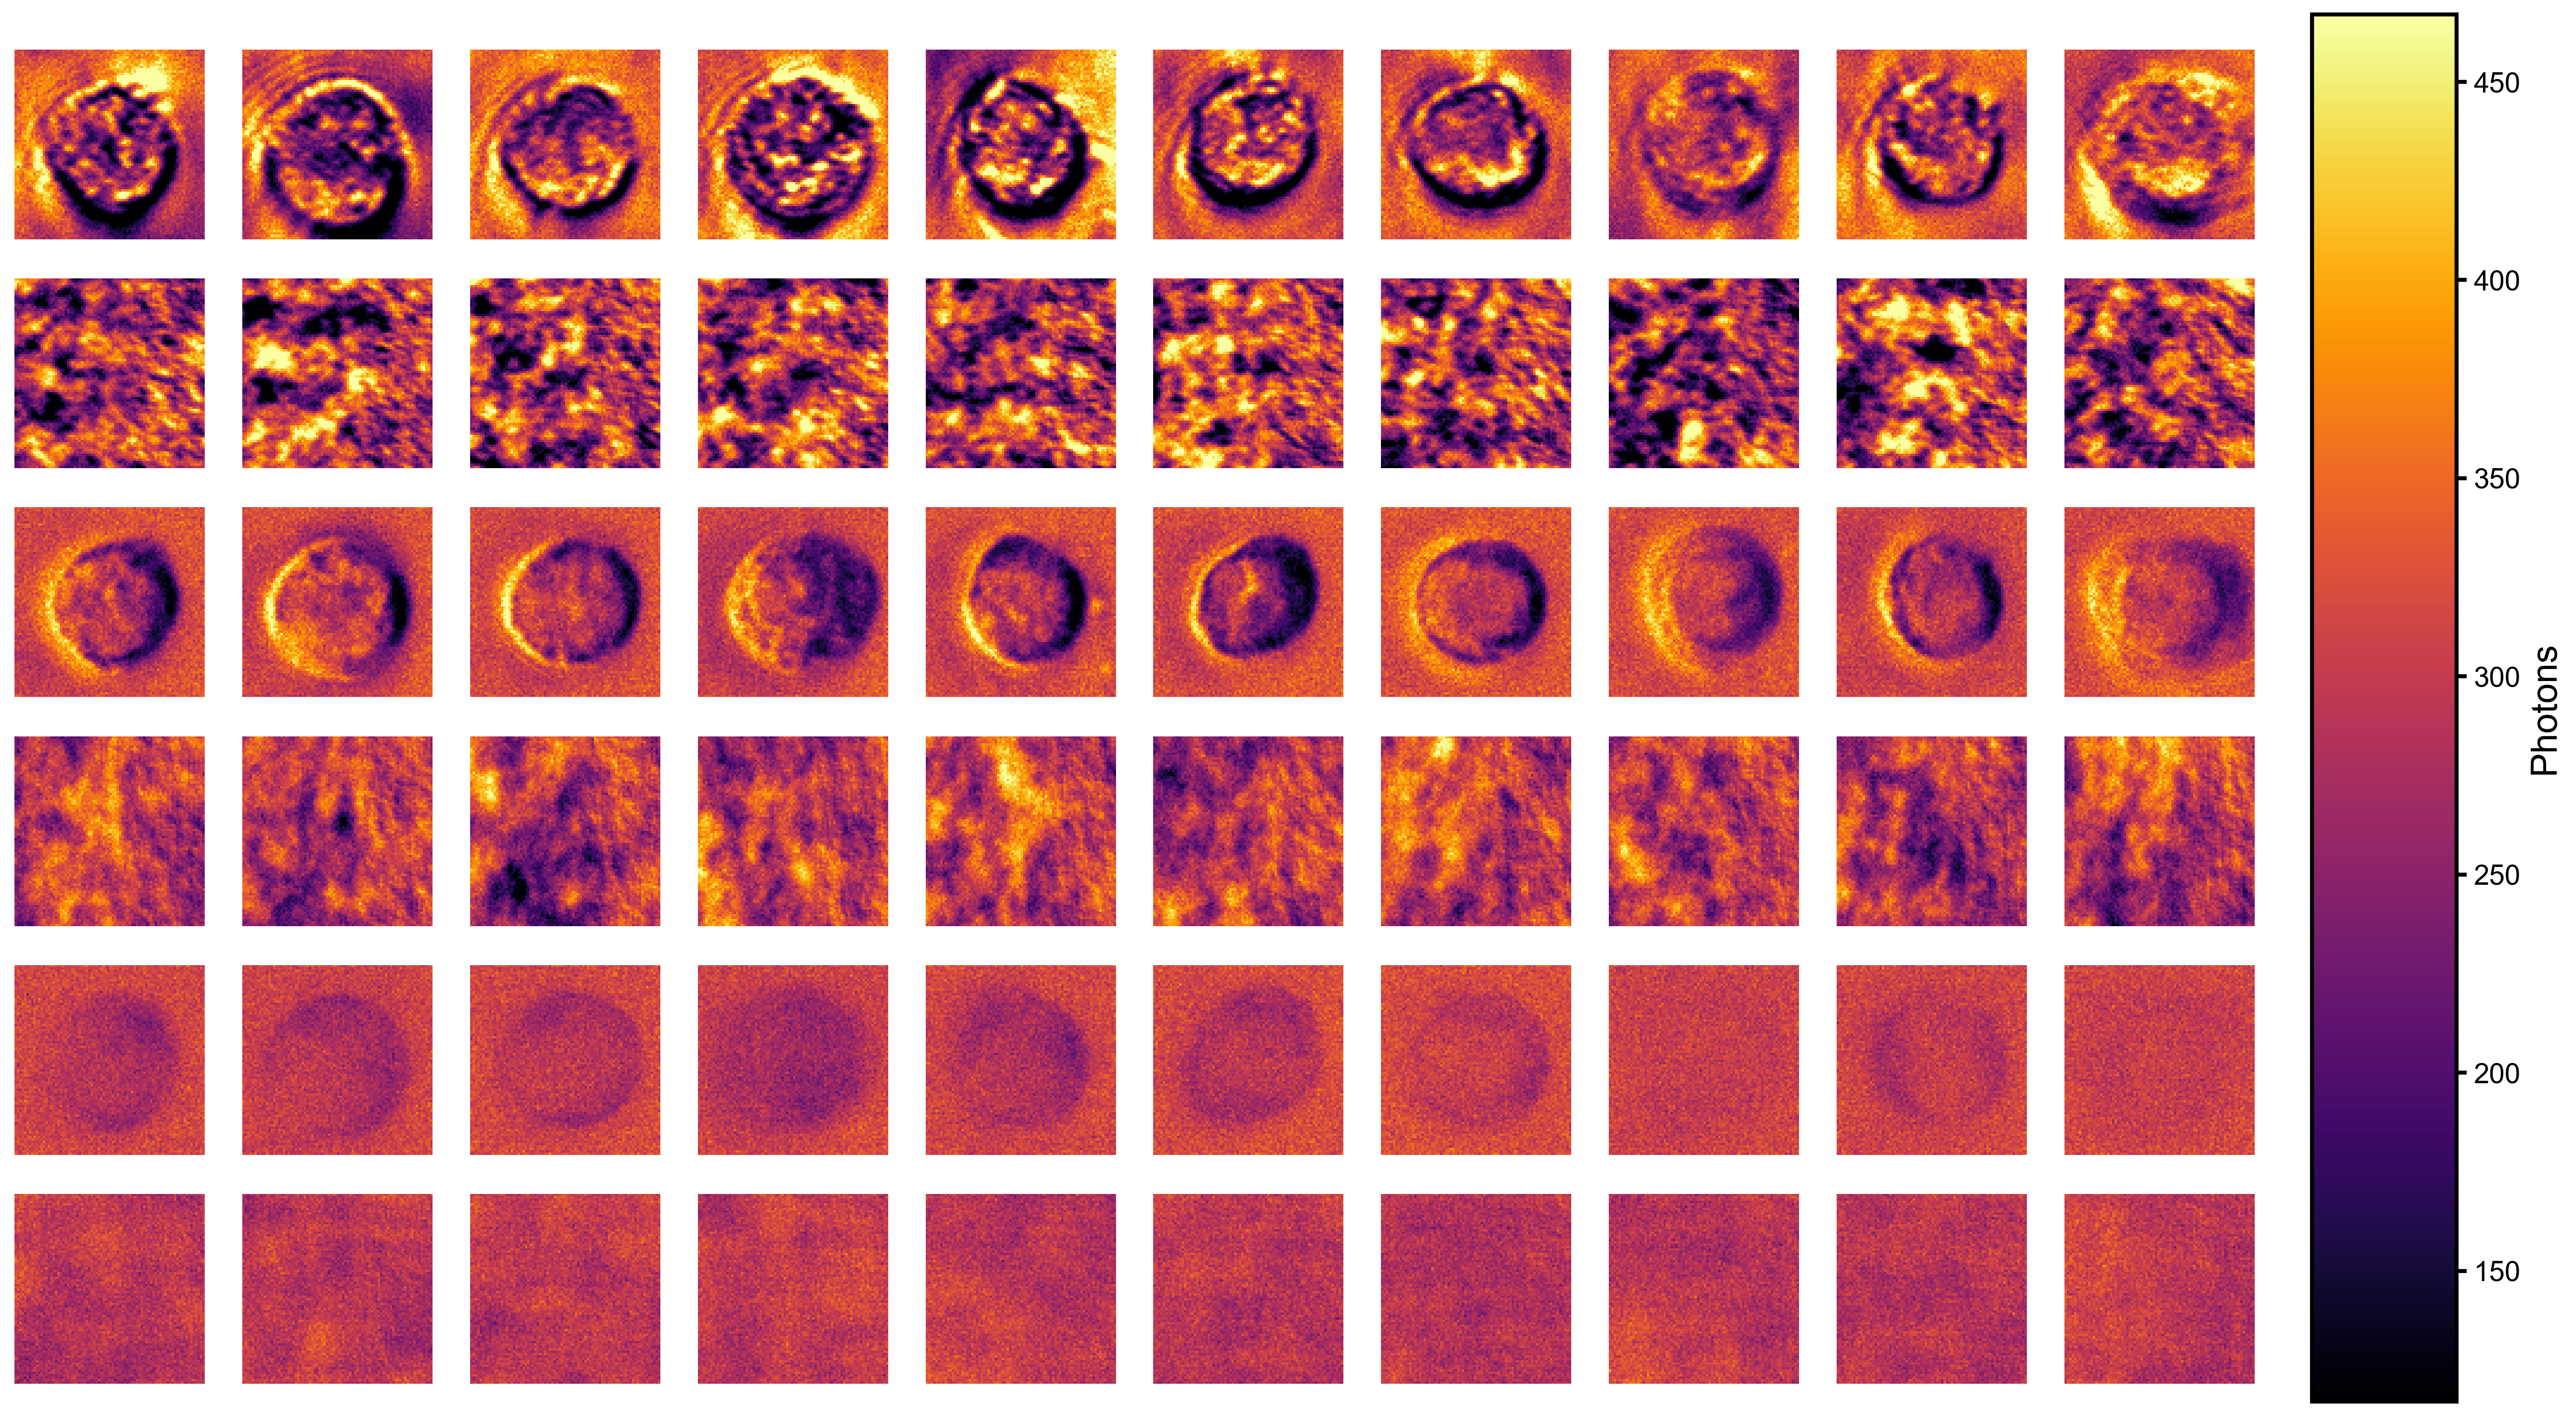

In [5]:
image_samples = image_samples_gp

# take the min and max over all channels
# concatenate all pixels for all channels from both images and samples
# then take the min and max over all pixels
all_pix = onp.concatenate([onp.array(noisy_patches_by_channel[channel]) for channel in channels])
vmin = np.percentile(all_pix, 1)
vmax = np.percentile(all_pix, 99)
# vmin, vmax = (60, 230)

fig, image_sample_ax = plt.subplots(len(channels) * 2, num_samples, 
                                figsize=(num_samples * 2, len(channels) * 2 * 2), dpi=300)
for channel_index, channel in enumerate(channels):
    # images = patches_by_channel[channel]
    images = onp.array(images_by_channel[channel])[[1, 3, 19, 5, 11, 22, 23, 24, 25, 26, 27, 28, 29 , 30]]
    noisy_images = add_shot_noise_to_experimenal_data(images, photon_fraction=photons_per_pixel / np.mean(images))
    samples = image_samples[channel]
    for i in range(num_samples):
        im = image_sample_ax[channel_index * 2, i].imshow(noisy_images[i], cmap='inferno', vmin=vmin, vmax=vmax)
        image_sample_ax[channel_index * 2, i].axis('off')
        image_sample_ax[channel_index * 2 + 1, i].imshow(samples[i], cmap='inferno', vmin=vmin, vmax=vmax)
        image_sample_ax[channel_index * 2 + 1, i].axis('off')
        

    image_sample_ax[channel_index*2, 0].set_ylabel(channel + '\n(images)')
    image_sample_ax[channel_index*2 + 1, 0].set_ylabel(channel + '\n(samples)')

# show one big colorbar on the right side spanning all rows
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.1, 0.05, 0.8])
sm = cm.ScalarMappable(cmap='inferno', norm=plt.Normalize(vmin=vmin, vmax=vmax))
fig.colorbar(sm, cax=cbar_ax, label='Photons')

fig.savefig('/home/hpinkard_waller/figures/mutual_information/' + 'intro_images_and_samples_gp' + '.pdf', transparent=True)

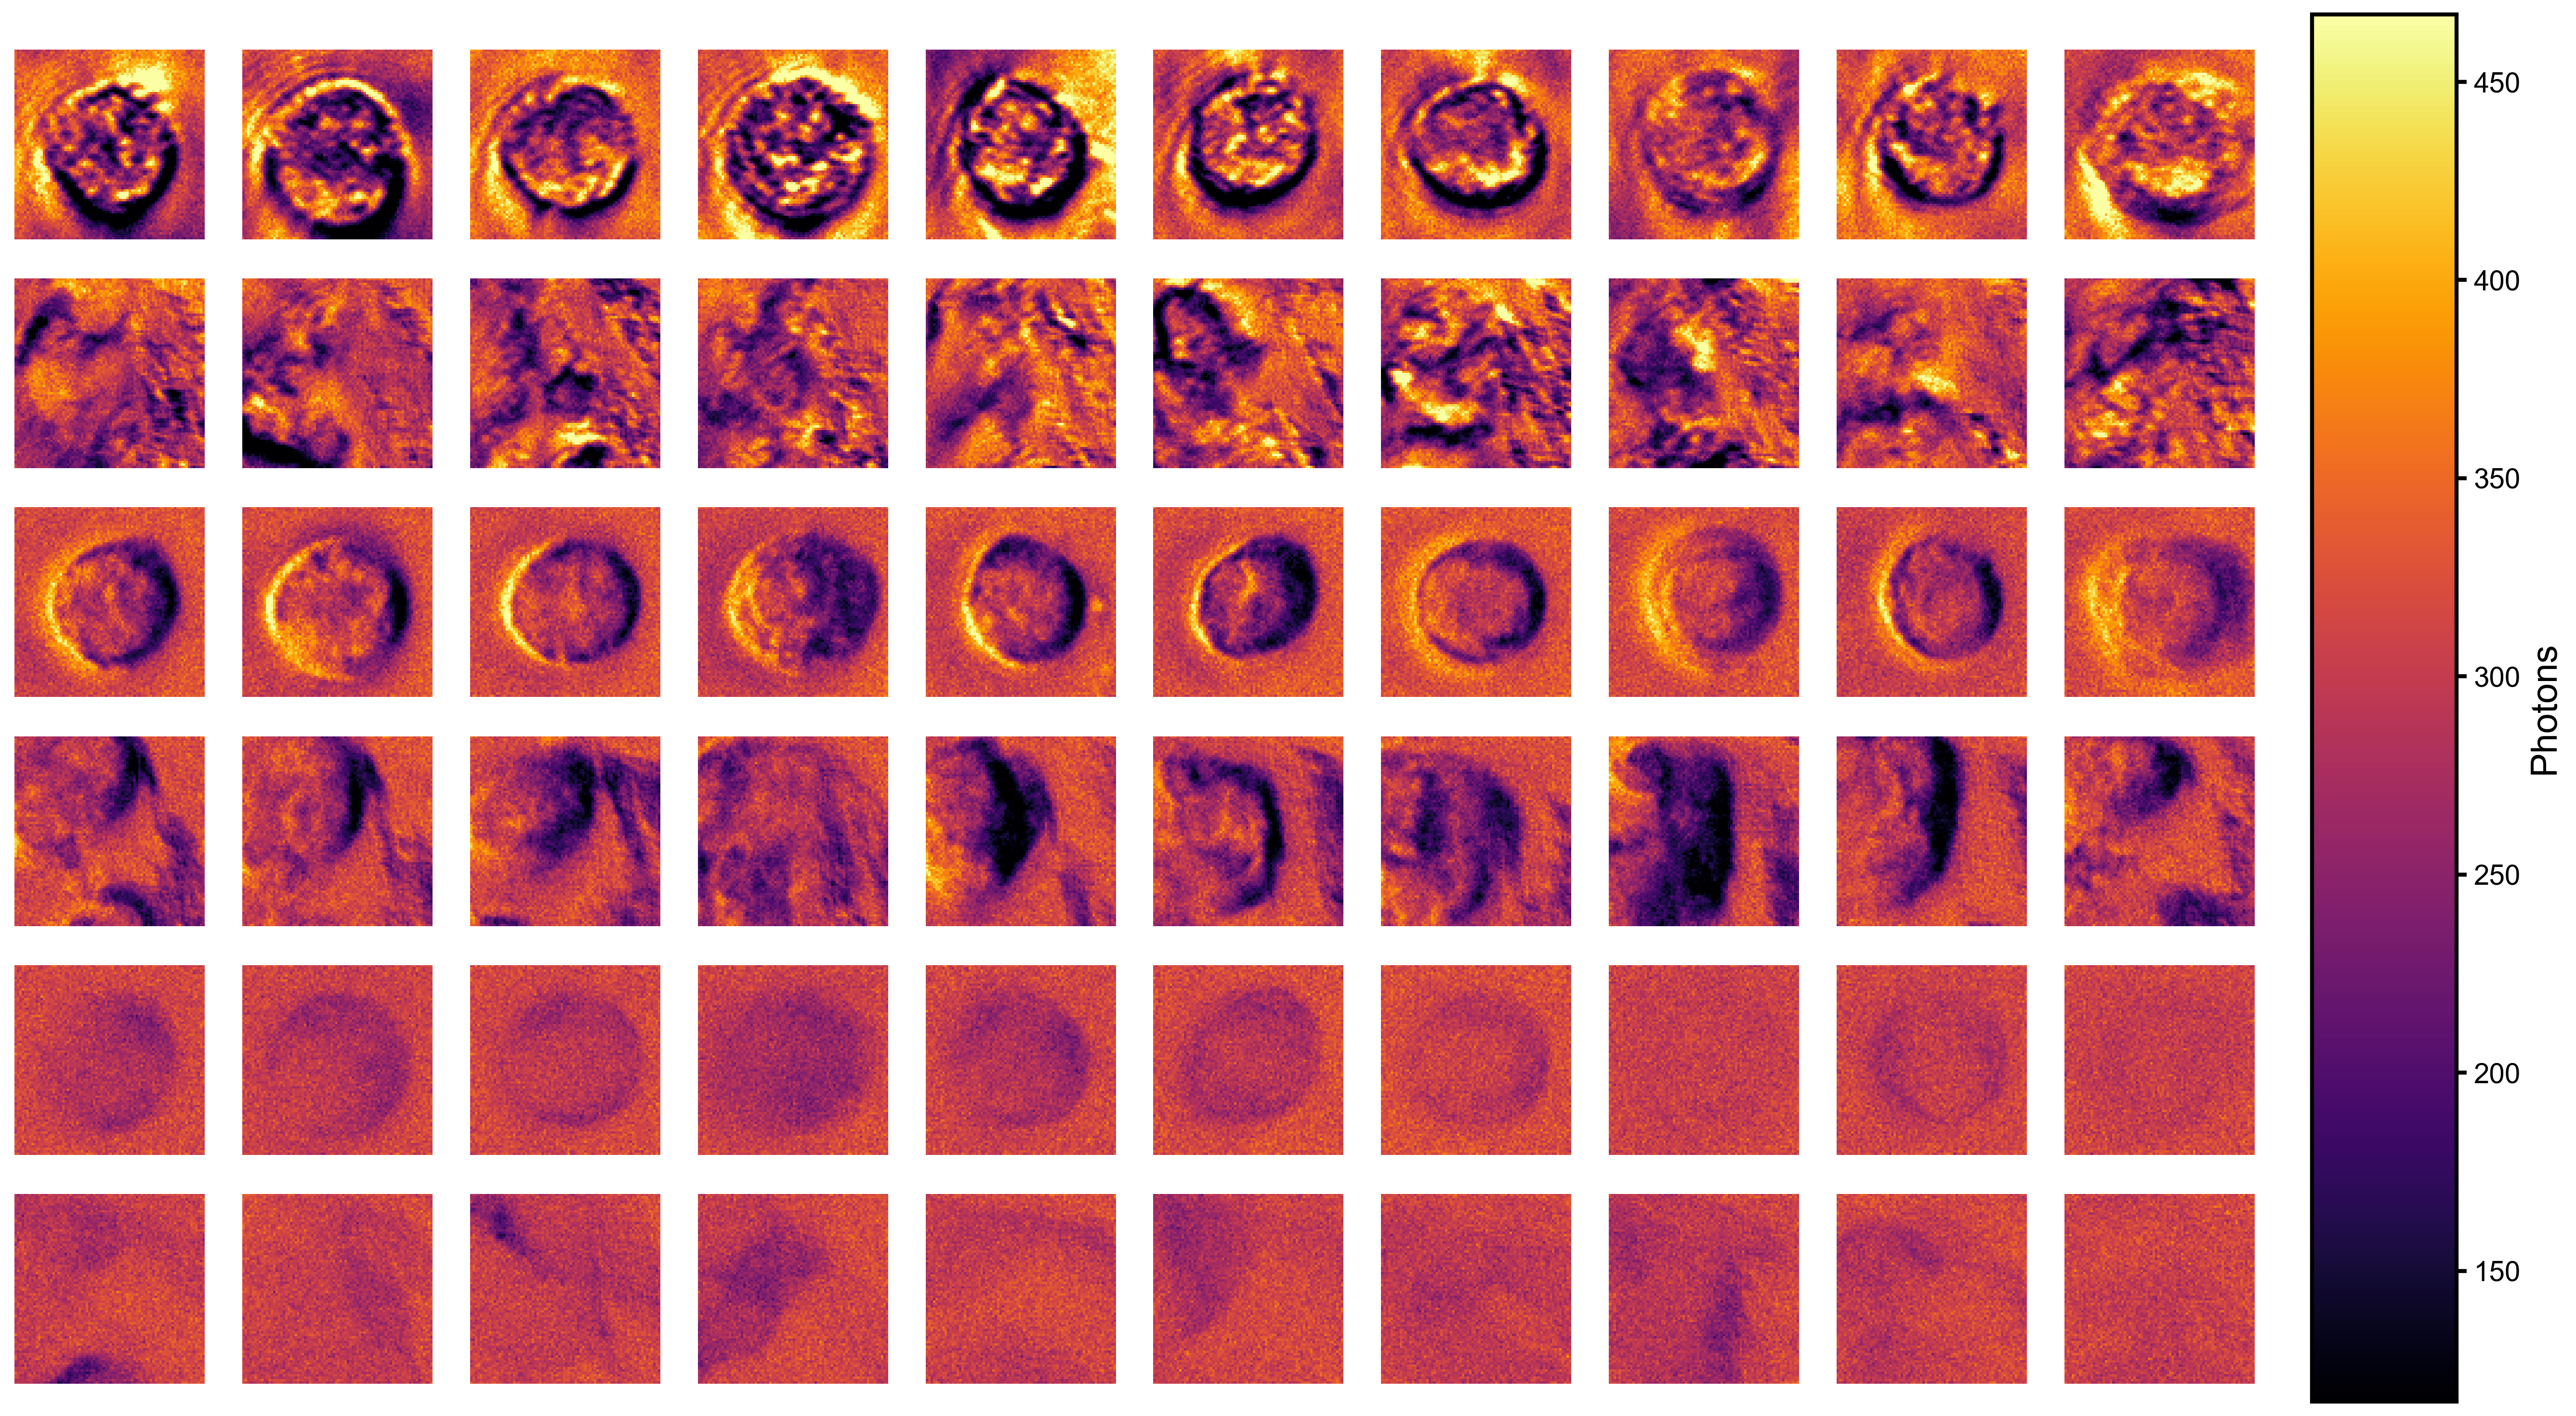

In [6]:
image_samples = image_samples_pcnn

# take the min and max over all channels
# concatenate all pixels for all channels from both images and samples
# then take the min and max over all pixels
all_pix = onp.concatenate([onp.array(noisy_patches_by_channel[channel]) for channel in channels])
vmin = np.percentile(all_pix, 1)
vmax = np.percentile(all_pix, 99)
# vmin, vmax = (60, 230)

fig, image_sample_ax = plt.subplots(len(channels) * 2, num_samples, 
                                figsize=(num_samples * 2, len(channels) * 2 * 2), dpi=300)
for channel_index, channel in enumerate(channels):
    # images = patches_by_channel[channel]
    images = onp.array(images_by_channel[channel])[[1, 3, 19, 5, 11, 22, 23, 24, 25, 26, 27, 28, 29 , 30]]
    noisy_images = add_shot_noise_to_experimenal_data(images, photon_fraction=photons_per_pixel / np.mean(images))
    samples = image_samples[channel]
    for i in range(num_samples):
        im = image_sample_ax[channel_index * 2, i].imshow(noisy_images[i], cmap='inferno', vmin=vmin, vmax=vmax)
        image_sample_ax[channel_index * 2, i].axis('off')
        image_sample_ax[channel_index * 2 + 1, i].imshow(samples[i], cmap='inferno', vmin=vmin, vmax=vmax)
        image_sample_ax[channel_index * 2 + 1, i].axis('off')
        

    image_sample_ax[channel_index*2, 0].set_ylabel(channel + '\n(images)')
    image_sample_ax[channel_index*2 + 1, 0].set_ylabel(channel + '\n(samples)')

# show one big colorbar on the right side spanning all rows
fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.1, 0.05, 0.8])
sm = cm.ScalarMappable(cmap='inferno', norm=plt.Normalize(vmin=vmin, vmax=vmax))
fig.colorbar(sm, cax=cbar_ax, label='Photons')

fig.savefig('/home/hpinkard_waller/figures/mutual_information/' + 'intro_images_and_samples_pixel_cnn' + '.pdf', transparent=True)